# Cel

Celem zadania jest oszacowanie energii wiązania represora ekspresji enzymu lacZ przeez represor lacl, który wiąże się do dokłądnie jednego miejsca przy miejscu startu transkrypcji.

W pracy [2] wyprowadzony został wzór określający krotność zmiany transkrypcji w zależności od różnych parametrów:

$foldchange= (1 + \frac{R}{N_{NS}} e^{-\Delta\epsilon_r/k_BT})^{-1}$,

gdzie: 
* $R$ - średnia liczba represorów na komórkę
* $N_{NS}$ - liczba możliwych miejsc wiązań dla represora
* $k_BT$ - energia cieplna sytemu
* $\Delta\epsilon_r$ - (szukana) energia wiązania represora

# Odtworzenie wyników analizy z [1]

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp

W pierwszym kroku po
bieramy przykładowe dane z pliku csv i prezentujemy je na wykresie logarytmicznym

In [9]:
#lacZ_titration_data = np.genfromtxt('lacZ_titration_data-2.csv', delimiter=',', usecols = (0, 1), names=True)
lacZ_titration_data = np.loadtxt('lacZ_titration_data-2.csv', delimiter=',', skiprows=1, usecols = (0,1))

Dane, wczytane jako macierz, pierwsza kolumna odpowiada średniej liczbie represorów w badanych komórkach ($R$), a druga kolumna zmianie stopnia ekspresji genu (**fold-change**). Wszystkie dane z pliku są dla operatora O2, więc kolumna ta została pominięta przy parsowaniu.

In [10]:
lacZ_titration_data

array([[2.242e+01, 1.756e-01],
       [5.934e+01, 4.519e-02],
       [1.240e+02, 2.151e-02],
       [2.553e+02, 1.241e-02]])

(10, 1000.0)

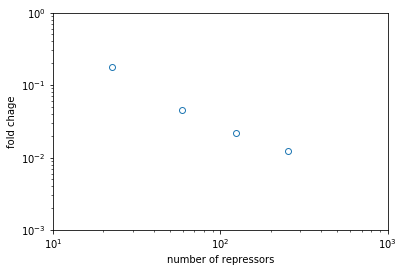

In [59]:
repressors = lacZ_titration_data.T[0]
foldChange = lacZ_titration_data.T[1]

plt.loglog(repressors, foldChange, 'o', markerfacecolor='w')
plt.xlabel('number of repressors')
plt.ylabel('fold chage')
plt.ylim([1e-3, 1])
plt.xlim([10, 1e3])

### Statystyka $\chi^2$

$\chi^2 = \displaystyle\sum_i \frac{(y_i - y(\alpha))^2}{\sigma_i^2}$

* $y_i$ - i-ta dana
* $y(\alpha)$ - wartość przewidywana y
* $\sigma_i^2$ - wariancja danych

Warotść $\alpha$, która minimalizuje $\chi^2$ uznwana jest za najlepsze dopasowanie parametru.

### Poszukiwanie najlepszej $\alpha$

Znamy zatem $R$, $N_{NS}$, **fold-change**, $k_BT$ (z definicji). Możemy, więc przystąpić do wynaczenia $\Delta\epsilon_r$.

Od wartości $\Delta\epsilon_r$ wymagamy, by minimalizowała różnicę pomiędzy zmierzonym, a przewidywanym **fold-change**.

Na początek zrobimy to metodą "na oko". Utworzymy wektor **epRange**, który rozpina nam wiele możliwych wartości $\Delta\epsilon_r$, po czym, obliczymy statystykę $\chi^2$ dla każdej z nich. Na wartości w **epRange** narzucimy pewne ograniczenia:

* $\Delta\epsilon_r < 0$ - zakładamy, że energia jest nieujemna, ponieważ represor posiada pewne powinowactwo do swojego miejsca wiążącego
* $\Delta\epsilon_r > -30 k_BT$ - energia powinna być mniejsza od najmocniejszego znanego [1] wiązania niekowalencyjnego (represor również wiąże się niekowalencyjnie

Text(0, 0.5, 'X^2')

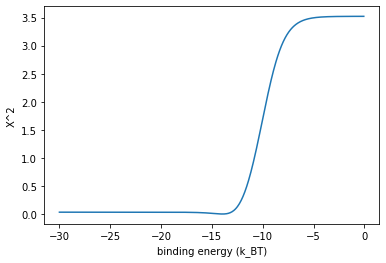

In [32]:
epRange = np.arange(-30, 0, 30/500)

chiSq = []

for ep in epRange:
    theoretical = (1 + (repressors/5e6) * np.exp(-ep))**-1
    chiSq.append(np.sum((theoretical - foldChange)**2))

plt.plot(epRange, chiSq)
plt.xlabel('binding energy (k_BT)')
plt.ylabel('X^2')

Minimum możemy łatwiej zaobserować po logarytmicznym przeskalowaniu wartości y:

Text(-10, 0.01, 'minimum')

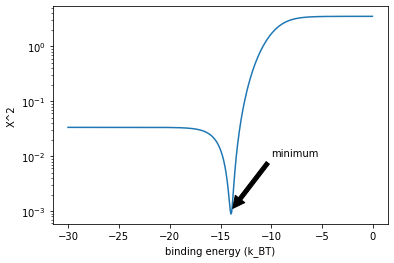

In [49]:
plt.semilogy(epRange, chiSq)
plt.xlabel('binding energy (k_BT)')
plt.ylabel('X^2')

plt.annotate('minimum', xy=(-14, 1e-3), xytext=(-10, 1e-2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

Próbujemy dopasować funkcję. Badamy dla 3 przypadków $\Delta\epsilon$:
* dobrego dopasowania, z wykresu szacujemy na -14 $k_BT$
* złego dopasowania: -20 oraz -10 $k_BT$

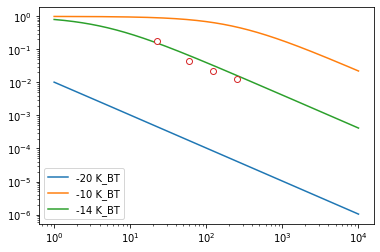

In [66]:
badEp1 = -20
badEp2 = -10
bestEp = -14

repRange = np.logspace(0, 4, 500)

epValues = np.array([badEp1, badEp2, bestEp])

repressors = lacZ_titration_data.T[0]
foldChange = lacZ_titration_data.T[1]

fits = []

for epValue in epValues:
    fits.append((1 + (repRange / 5E6) * np.exp(-epValue))**-1);

plt.loglog(repRange, fits[0], label='-20 K_BT')
plt.loglog(repRange, fits[1], label='-10 K_BT')
plt.loglog(repRange, fits[2], label='-14 K_BT')

plt.loglog(repressors, foldChange, 'o', markerfacecolor='w');
plt.legend()

Widzimy, że $\Delta\epsilon = -14 k_BT$ jest dobrym dopasowaniem, ponieważ ładnie pokrywa się z danymi eksprymentalnymi

In [74]:
def residFunc(ep):
    theoretical = (1 + (repressors/5e6) * np.exp(-ep))**-1
    return np.sum((theoretical - foldChange)**2)

sp.least_squares(residFunc, [-14], method='lm')

 active_mask: array([0])
        cost: 3.8443111912205733e-07
         fun: array([0.00087685])
        grad: array([-9.30830233e-12])
         jac: array([[-1.06156408e-08]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 15
        njev: None
  optimality: 9.308302332784792e-12
      status: 2
     success: True
           x: array([-13.96154072])

## Testy dla operonów O1 i O3

Dane testowe pobrane zostały odpowiednio do plików lacZ-O1.csv oraz lacZ-O3.csv, a uzyskane przez przetworzenie wykresu S7B z supplementu do [2] w programi PlotDigitalizer [3]

In [86]:
O1_data = np.loadtxt('lacZ-O1.csv', delimiter=',', skiprows=1)
print(O1_data)
repressorsO1 = O1_data.T[0]
foldChangeO1 = O1_data.T[1]

def residFuncO1(ep):
    theoretical = (1 + (repressorsO1/5e6) * np.exp(-ep))**-1
    return np.sum((theoretical - foldChangeO1)**2)

sp.least_squares(residFuncO1, [-14], method='lm')


[[1.11850552e+01 3.48403684e-02]
 [2.95676712e+01 8.15745941e-03]
 [6.16429293e+01 4.37032316e-03]
 [1.27367424e+02 2.58385530e-03]
 [6.08200388e+02 1.43051414e-03]
 [8.66449371e+02 1.05050471e-03]]


 active_mask: array([0])
        cost: 4.1205794157671616e-10
         fun: array([2.87074186e-05])
        grad: array([-2.85349556e-13])
         jac: array([[-9.9399239e-09]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 27
        njev: None
  optimality: 2.8534955626333297e-13
      status: 2
     success: True
           x: array([-16.39652613])

In [91]:
O3_data = np.loadtxt('lacZ-O3.csv', delimiter=',', skiprows=1)
print(O3_data)
repressorsO3 = O3_data.T[0]
foldChangeO3 = O3_data.T[1]

def residFuncO3(ep):
    theoretical = (1 + (repressorsO3/5e6) * np.exp(-ep))**-1
    return np.sum((theoretical - foldChangeO3)**2)

sp.least_squares(residFuncO3, [-14], method='lm')

[[1.11850552e+01 6.74242272e-01]
 [2.95676712e+01 5.53635546e-01]
 [6.19196929e+01 5.25290358e-01]
 [1.27367424e+02 4.03902692e-01]
 [6.05481903e+02 2.14972205e-01]
 [8.66449371e+02 1.51764347e-01]]


 active_mask: array([0])
        cost: 0.0026604892451516263
         fun: array([0.07294504])
        grad: array([6.80286043e-09])
         jac: array([[9.32600855e-08]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 18
        njev: None
  optimality: 6.8028604292975254e-09
      status: 2
     success: True
           x: array([-11.37272331])

In [93]:
O2_data = np.loadtxt('lacZ-O2.csv', delimiter=',', skiprows=1)
print(O2_data)
repressorsO2 = O2_data.T[0]
foldChangeO2 = O2_data.T[1]

def residFuncO2(ep):
    theoretical = (1 + (repressorsO2/5e6) * np.exp(-ep))**-1
    return np.sum((theoretical - foldChangeO2)**2)

sp.least_squares(residFuncO2, [-14], method='lm')

[[1.11850552e+01 1.51764347e-01]
 [2.97004238e+01 4.02578163e-02]
 [6.19196929e+01 1.94160004e-02]
 [1.27367424e+02 1.12552516e-02]
 [6.08200388e+02 5.28752576e-03]
 [8.70339544e+02 4.28503478e-03]]


 active_mask: array([0])
        cost: 1.4853902604513475e-07
         fun: array([0.00054505])
        grad: array([-1.03197691e-12])
         jac: array([[-1.89336653e-09]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 21
        njev: None
  optimality: 1.0319769073406805e-12
      status: 2
     success: True
           x: array([-14.81596438])

## Referencje
[1] Nonlinear Regression

[2] Quantitative dissection of the simple repression input–output function